# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, Model
from scipy.fftpack import fft, ifft, fftfreq

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'TA02_GP101'),
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('wind', 'Wx'),
    ('wind', 'Wy'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
              TA02_GP101          11
state         TA01_output         15
              TA02_output         14
temperatures  TA01_GT10X_GM10X    14
              DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     12
              DC_GT301_outdoor    12
humidity      TA01_GT10X_GM10X    15
              DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      14
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  3
              gsi_deriv            3
              vol                  3
              vol_deriv            3
wind          Wx             

In [6]:
# remove single NAN
data = data.dropna(how='any')

### Remove (possibly) erroneous measurements

In [7]:
cols = [
    'DC_GT101_GM101',
    'DC_GT102_GM102',
    'DC_GT103_GM103',
    'DC_GT104_GM104'
]

for col in cols:
    data[('flag', col)] = (((data.temperatures[col] - data.temperatures[col].shift(1)) < -1) \
                            & ((data.humidity[col] - data.humidity[col].shift(1)) > 5)) \
                            | (data.humidity[col] > 70)

    hrs = data.groupby(['month', 'day', 'hour']).sum()[('flag', col)] > 0
#     days = data.groupby(['month', 'day']).sum()[('flag', col)] > 0
    hrsDrop = hrs[hrs == 1].index.values
    mask = np.array([hr not in list(hrsDrop) for hr in data.index.droplevel(-1).droplevel(-1).values])
    data = data[mask]
    

# Feature engineering

### DC-temp scaling

In [8]:
data[('state', 'TA01_output_minmax')] = (data.state.TA01_output - data.state.TA01_output.min()) / (data.state.TA01_output.max() - data.state.TA01_output.min())
data[('state', 'TA02_output_minmax')] = (data.state.TA02_output - data.state.TA02_output.min()) / (data.state.TA02_output.max() - data.state.TA02_output.min())
data[('flow', 'TA01_minmax')] = (data.flow.TA01_GP101 - data.flow.TA01_GP101.min()) / (data.flow.TA01_GP101.max() - data.flow.TA01_GP101.min())
data[('flow', 'TA02_minmax')] = (data.flow.TA02_GP101 - data.flow.TA02_GP101.min()) / (data.flow.TA02_GP101.max() - data.flow.TA02_GP101.min())

data[('temperatures', 'DC_GT401_GM401_scaled')] = data.temperatures.DC_GT401_GM401 * data.flow.TA01_minmax
data[('temperatures', 'TA01_GT401_GM401_scaled')] = data.temperatures.TA01_GT401_GM401 * data.flow.TA01_minmax
data[('temperatures', 'DC_GT301_damped_scaled')] = data.temperatures.DC_GT301_damped * data.flow.TA02_minmax

## Split TRAIN / TEST

In [278]:
## Randomly select days for trainin and testing
days = data.groupby(['month', 'day'], sort=False).count().index.values

# get number of days f. testing / training
train_frac = 0.95
train_n = int(len(days) * train_frac)
test_n = len(days) - train_n

# split dataset
# np.random.shuffle(days)
mask = np.array([day in list(days[:train_n]) for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
data_train = data.loc[mask].copy()
data_test = data.loc[~mask].copy()

# del data

## NOISE reduction

### FFT f. TRAIN data

In [279]:
# cols = [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
#     ('temperatures', 'DC_GT401_GM401'),
#     ('temperatures', 'TA01_GT401_GM401'),
# #     ('temperatures', 'DC_GT301_outdoor'),
# #     ('temperatures', 'DC_GT301_damped'),
#     ('humidity', 'DC_GT102_GM102'),
#     ('humidity', 'DC_GT103_GM103'),
#     ('humidity', 'DC_GT104_GM104'),
# ]

# for col in cols:
# #     sig_fft = fft(data.humidity[col].values)
#     sig_fft = fft(data_train[col].values)
#     sig_fft_filtered = sig_fft.copy()
#     sig_fft_noise = sig_fft.copy()
    
#     #
#     freq = fftfreq(len(data_train), d=1/10)
#     cut_off = 1
    
#     sig_fft_filtered[np.abs(freq) > cut_off] = 0
#     sig_fft_noise[np.abs(freq) <= cut_off] = 0
    
#     # get the filtered signal in time domain
#     filtered = ifft(sig_fft_filtered)
#     noise = ifft(sig_fft_noise)
    
# #     plt.plot(data_train[col].values[-50:])
# #     plt.plot(filtered[-50:])
# #     plt.show()
# #     break
    
#     # put in data
# #     data.humidity.loc[:, col + '_noise'] = data.humidity[col]
#     data_train.loc[:, col] = filtered

In [280]:
# cols = [
#     (('temperatures', 'DC_GT102_GM102'), 4),
#     (('temperatures', 'DC_GT103_GM103'), 4),
#     (('temperatures', 'DC_GT104_GM104'), 4),
# #     (('temperatures', 'DC_GT401_GM401'), 3), #3),
#     (('temperatures', 'TA01_GT401_GM401'), 3), #3),
#     (('temperatures', 'TA01_GT401_GM401_scaled'), 3), #3),
#     (('temperatures', 'DC_GT301_outdoor'), 4),
#     (('temperatures', 'DC_GT301_damped'), 4),
#     (('temperatures', 'DC_GT301_damped_scaled'), 4),
#     (('humidity', 'DC_GT102_GM102'), 4),
#     (('humidity', 'DC_GT103_GM103'), 4),
#     (('humidity', 'DC_GT104_GM104'), 4),
# ]

# for colSpec in cols:
#     for day in data_train.groupby(['month', 'day']).count().index.values:
#         # apply KALMAN filter to measurements
#         col = colSpec[0]
#         varExp = colSpec[-1]

#         # get data
#         X = data_train.loc[day, col].values
#         n = len(X)

#         # process variance, measurement variance
#         Q = 1e-5
#         R = 0.1**varExp

#         xhat=np.zeros(n)      # a posteri estimate of x
#         P=np.zeros(n)         # a posteri error estimate
#         xhatminus=np.zeros(n) # a priori estimate of x
#         Pminus=np.zeros(n)    # a priori error estimate
#         K=np.zeros(n)         # gain or blending factor

#         # intial guesses
#         xhat[0] = X[0]
#         P[0] = 1

#         for k in range(1,n):
#             # time update
#             xhatminus[k] = xhat[k-1]
#             Pminus[k] = P[k-1]+Q

#             # measurement update
#             K[k] = Pminus[k]/( Pminus[k]+R )
#             xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
#             P[k] = (1-K[k])*Pminus[k]

#         data_train.loc[day, col] = xhat

In [281]:
### create "better" estimate of temperature var, w. proper avg.
data_train[('temperatures', 'TA01_GT10X_GM10X')] = data_train.temperatures[[
#     ('DC_GT101_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

# # adjust for setpoint change
# data_train[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_train[('setpoints', 'TA01_GT10X_GM10X')])

In [282]:
### create "better" estimate of humidity var, w. proper avg.
data_train[('humidity', 'TA01_GT10X_GM10X')] = data_train.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

### KALMAN f. TEST data

In [283]:
cols = [
#     (('temperatures', 'TA01_GT10X_GM10X'), 3)
#     (('temperatures', 'DC_GT102_GM102'), 3),
#     (('temperatures', 'DC_GT103_GM103'), 3),
#     (('temperatures', 'DC_GT104_GM104'), 3),
#     (('temperatures', 'DC_GT401_GM401'), 3), #3),
#     (('temperatures', 'DC_GT401_GM401_scaled'), 3), #3),
#     (('temperatures', 'TA01_GT401_GM401'), 3), #3),
#     (('temperatures', 'TA01_GT401_GM401_scaled'), 3), #3),
#     (('temperatures', 'DC_GT301_outdoor'), 3),
#     (('temperatures', 'DC_GT301_damped'), 3),
#     (('temperatures', 'DC_GT301_damped_scaled'), 3),
#     (('humidity', 'DC_GT102_GM102'), 3),
#     (('humidity', 'DC_GT103_GM103'), 3),
#     (('humidity', 'DC_GT104_GM104'), 3),
]

for colSpec in cols:
    for day in data_test.groupby(['month', 'day']).count().index.values:
        # apply KALMAN filter to measurements
        col = colSpec[0]
        varExp = colSpec[-1]

        # get data
        X = data_test.loc[day, col].values
        n = len(X)

        # process variance, measurement variance
        Q = 1e-5
        R = 0.1**varExp

        xhat=np.zeros(n)      # a posteri estimate of x
        P=np.zeros(n)         # a posteri error estimate
        xhatminus=np.zeros(n) # a priori estimate of x
        Pminus=np.zeros(n)    # a priori error estimate
        K=np.zeros(n)         # gain or blending factor

        # intial guesses
        xhat[0] = X[0]
        P[0] = 1

        for k in range(1,n):
            # time update
            xhatminus[k] = xhat[k-1]
            Pminus[k] = P[k-1]+Q

            # measurement update
            K[k] = Pminus[k]/( Pminus[k]+R )
            xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
            P[k] = (1-K[k])*Pminus[k]

#         plt.plot(data_test.loc[day, col].values)
#         plt.plot(xhat)
#         plt.show()
#         break
            
        data_test.loc[day, col] = xhat

In [284]:
### create "better" estimate of temperature var, w. proper avg.
data_test[('temperatures', 'TA01_GT10X_GM10X')] = data_test.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)


# # adjust for setpoint change
# data_test[('temperatures', 'TA01_GT10X_GM10X')] += (20.0 - data_test[('setpoints', 'TA01_GT10X_GM10X')])

In [285]:
### create "better" estimate of humidity var, w. proper avg.
data_test[('humidity', 'TA01_GT10X_GM10X')] = data_test.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [286]:
# fig, ax = plt.subplots()

# # ax.plot(data.temperatures.TA01_GT10X_GM10X.values[-12500:])
# ax.plot(data.temperatures.TA01_GT10X_GM10X.values[-10000:-9500])
# # ax.plot(data.temperatures.DC_GT102_GM102.values[-12500:-9000])
# # ax.plot(data.temperatures.DC_GT103_GM103.values[-12500:-9000])
# # ax.plot(data.temperatures.DC_GT301_damped_scaled.values[-12500:])

# ax2 = ax.twinx()
# ax2.plot(data.temperatures.TA01_GT401_GM401.values[-10000:-9500], 'r')
# # ax2.plot(data.sun.gsi.values[-12500:], 'r')
# plt.show()

### Reduce to M-min observations

In [287]:
# set min per observation
m = 1

In [288]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
idxObj = zip(
    data_train.index.get_level_values(0),
    data_train.index.get_level_values(1),
    data_train.index.get_level_values(2),
    data_train.index.get_level_values(3) // m
)

index = pd.MultiIndex.from_tuples(
    tuples=idxObj,
    names=['month', 'day', 'hour', 'minute']
)

data_train.index = index
data_train = data_train.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

In [289]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
idxObj = zip(
    data_test.index.get_level_values(0),
    data_test.index.get_level_values(1),
    data_test.index.get_level_values(2),
    data_test.index.get_level_values(3) // m
)

index = pd.MultiIndex.from_tuples(
    tuples=idxObj,
    names=['month', 'day', 'hour', 'minute']
)

data_test.index = index
data_test = data_test.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()

### Normalization

In [290]:
# Define model variables
model_vars = [
    ('state', 'TA01_output'),
    ('state', 'TA02_output'),
#     ('flow', 'TA01_GP101'),
#     ('flow', 'TA02_GP101'),
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
#     ('temperatures', 'DC_GT401_GM401_scaled'),
#     ('temperatures', 'TA01_GT401_GM401_scaled'),
#     ('temperatures', 'DC_GT301_damped_scaled'),
#     ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
#     ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
#     ('sun', 'vol_deriv'),
#     ('wind', 'Wx'),
#     ('wind', 'Wy'),
    ('time', 'minofday'),
    ('time', 'dayofyear')
]

# filter data
data_train = data_train[model_vars].copy()
data_test = data_test[model_vars].copy()

In [291]:
col_params = {}
for col in data_train.columns:
    cat, var = col
    
#     if cat == 'temperatures' and var == 'TA01_GT10X_GM10X':
#         continue
    
    # normalize
    mean = data_train[col].mean()
    std = data_train[col].std()
    
    data_train[col] = (data_train[col] - mean) / std
    data_test[col] = (data_test[col] - mean) / std
    
#     # make positive
#     min_val = data_train[col].min()
#     data_train[col] = data_train[col] + abs(min(0, min_val))
#     min_val = max(0, min_val)
#     max_val = data_train[col].max()
#     data_train[col] = (data_train[col] - min_val) / (max_val - min_val)
    
#     data_test[col] = data_test[col] + abs(min(0, min_val))
#     data_test[col] = (data_test[col] - min_val) / (max_val - min_val)
#     data_test[col] = data_test[col].apply(lambda val: max(val, 0.0))
# #     data_test[col] = data_test[col].apply(lambda val: max(min(val, 1.0), 0.0))
    
#     col_params[col] = {
# #         'mean':mean,
# #         'std':std,
#         'max':max_val,
#         'min':min_val
#     }

## Data preparation

In [292]:
t_steps = 10    # 5 x 2 = 10-min predictions
n_steps = 60    # 5 x 12 = 60-min backwards look

In [293]:
# targets_train = data_train[('temperatures', 'TA01_GT10X_GM10X')].copy()
# targets_test = data_test[('temperatures', 'TA01_GT10X_GM10X')].copy()

In [294]:
targets_train = pd.concat([data_train.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
]], axis=1)
# targets_train = (targets_train - targets_train.shift(t_steps)) * 100

targets_test = pd.concat([data_test.pop(col) for col in [
#     ('temperatures', 'DC_GT102_GM102'),
#     ('temperatures', 'DC_GT103_GM103'),
#     ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'TA01_GT10X_GM10X'),
]], axis=1)
# targets_test = (targets_test - targets_test.shift(t_steps)) * 100

In [295]:
# targets_train *= 10
# targets_test *= 10

In [296]:
# temps_train = targets_train[:-n_steps]#.values
# temps_test = targets_test[:-n_steps]#.values

### Create sequences

In [297]:
def date_flagger(data, n_steps):
    # get flagged datesvalues
#     data['minute'] = data.index.get_level_values(3).values    
#     data['date_flag'] = data.minute - data.minute.shift(n_steps) != (n_steps)

    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 2
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [298]:
def seq_maker_single(data, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    
    return sequences

def seq_maker(data, targets, temps, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    #temps = temps[mask].values
    
    return sequences, targets#, temps

In [299]:
# make temp seuqences
temps_train = seq_maker_single(targets_train, n_steps)
temps_test = seq_maker_single(targets_test, n_steps)

In [300]:
# make sequences
sequences_train, targets_train = seq_maker(data_train, targets_train, temps_train, n_steps)
sequences_test, targets_test = seq_maker(data_test, targets_test, temps_test, n_steps)

In [301]:
# for t in range(1, t_steps+1):
#     sequences_test[:, -t, :] = sequences_test[:, -(t_steps+2), :]
# #     sequences_train[:, -t, :] = sequences_train[:, -(t_steps+2), :]

In [302]:
# sequences_train, temps_train, targets_train = sequences_train[:-1], temps_train[:-1], targets_train[1:]
# sequences_test, temps_test, targets_test = sequences_test[:-1], temps_test[:-1], targets_test[1:]

In [303]:
# # shuffle training data randomly
# idxs = np.arange(len(targets_train))
# np.random.shuffle(idxs)

# sequences_train = sequences_train[idxs]
# targets_train = targets_train[idxs]

In [304]:
sequences_train, temps_train, targets_train = sequences_train[t_steps:], temps_train[:-t_steps], targets_train[t_steps:]
sequences_test, temps_test, targets_test = sequences_test[t_steps:], temps_test[:-t_steps], targets_test[t_steps:]

## Define Recurrent NN

In [312]:
tf.keras.backend.clear_session()

In [313]:
decoder_inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))
decoder_inputs = layers.LayerNormalization()(decoder_inputs)

decoder, state_l1 = layers.GRU(units=128, recurrent_dropout=0.2, return_sequences=True, return_state=True)(decoder_inputs)
# decoder, state_l2 = layers.SimpleRNN(units=32, recurrent_dropout=0.5, return_sequences=True, return_state=True)(decoder)
_, state_l3 = layers.GRU(units=128, recurrent_dropout=0.5, return_sequences=False, return_state=True)(decoder)

encoder_inputs = layers.Input(shape=(temps_train.shape[1], temps_train.shape[2]))
encoder_inputs = layers.GaussianNoise(stddev=0.0)(encoder_inputs)
encoder_inputs = layers.LayerNormalization()(encoder_inputs)

encoder = layers.GRU(units=128, recurrent_dropout=0.2, return_sequences=True)(inputs=encoder_inputs, initial_state=state_l1)
# encoder = layers.SimpleRNN(units=32, recurrent_dropout=0.5, return_sequences=True)(inputs=encoder, initial_state=state_l2)
encoder = layers.GRU(units=128, recurrent_dropout=0.5, return_sequences=False)(inputs=encoder, initial_state=state_l3)
encoder = layers.LayerNormalization()(encoder)

output = layers.Dense(units=1, activation=None)(encoder)

model = Model(inputs=[decoder_inputs, encoder_inputs], outputs=output)

In [314]:
# temp_inputs = layers.Input(shape=(1,))
# temp = layers.GaussianNoise(stddev=0.0)(temp_inputs)

# inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))
# inputs = layers.LayerNormalization()(inputs)

# _, _, state = layers.LSTM(units=32, recurrent_dropout=0.5, return_state=True, return_sequences=False)(inputs=inputs)
# # state = layers.LayerNormalization()(state)
# # state = layers.LayerNormalization()(state)
# # state = layers.Dropout(0.5)(state)

# layer = layers.Concatenate()([temp, state])
# layer = layers.LayerNormalization()(layer)
# layer = layers.Dense(units=1, activation=None)(layer)
# # layer = layers.Add()([inputs, layer])
# # layer = layers.Concatenate()([state, temp])
# # layer = layers.Concatenate()([layer, temp])
# # layer = layers.LayerNormalization()(layer)
# # layer = layers.Concatenate()([layer, temp])
# # layer = layers.Dropout(0.5)(layer)
# # layer = layers.Dense(units=32, activation='relu')(layer)
# # layer = layers.LayerNormalization()(layer)

# model = Model(inputs=[temp_inputs, inputs], outputs=layer)

In [315]:
# inputs = layers.Input(shape=(sequences_train.shape[1], sequences_train.shape[2]))
# inputs = layers.LayerNormalization()(inputs)

# layer, state = layers.GRU(units=32, recurrent_dropout=0.5, return_sequences=True, return_state=True)(inputs)
# layer = layers.Attention()([layer, layer])
# _, state = layers.GRU(units=32, recurrent_dropout=0.5, return_state=True)(inputs=layer, initial_state=state)

# # layer = layers.Add()([inputs, layer])
# # layer = layers.Concatenate()([state, temp])
# # layer = layers.Concatenate()([layer, temp])
# layer = layers.LayerNormalization()(state)
# # layer = layers.Concatenate()([layer, temp])
# layer = layers.Dense(units=1, activation=None)(layer)

# model = Model(inputs=inputs, outputs=layer)

In [316]:
# lr = 0.005
lr = 0.001
# lr = 0.0005
# model = tf.keras.models.Sequential(layers=layerList, name='model')
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
# model.compile(optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=lr), loss='mse')
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 10)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 gru (GRU)                      [(None, 60, 128),    53760       ['input_3[0][0]']                
                                 (None, 128)]                                                     
                                                                                                  
 gru_2 (GRU)                    (None, 60, 128)      50304       ['input_4[0][0]',            

In [317]:
# model2 = tf.keras.models.load_model(save_path + 'temp_diff_model_v103')
# model2.summary()

In [318]:
# # copy weigths from pre-trained
# for idx, layer in enumerate(model.layers):
#     layer.set_weights(model2.layers[idx].get_weights())

In [319]:
trainHist = model.fit(
    [sequences_train, temps_train],
#     sequences_train,
    targets_train,
    epochs=50,
    batch_size=128,
#     validation_split=0.0,
    validation_data = ([sequences_test, temps_test], targets_test),
#     validation_data = (sequences_test, targets_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/50
  30/1410 [..............................] - ETA: 1:43:12 - loss: 1.7080

KeyboardInterrupt: 

In [883]:
# model_name = 'temp_diff_model_v104'
# model.save(save_path + model_name)

INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_diff_model_v103\assets


INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_diff_model_v103\assets


In [ ]:
# model = tf.keras.models.load_model(save_path + 'temp_diff_model_v202')
# model.summary()

In [240]:
preds = np.squeeze(model.predict([sequences_test, temps_test]))
# preds = np.squeeze(model.predict(sequences_test))

355/355 [==============================] - 22s 58ms/step


In [241]:
preds.shape

(11331,)

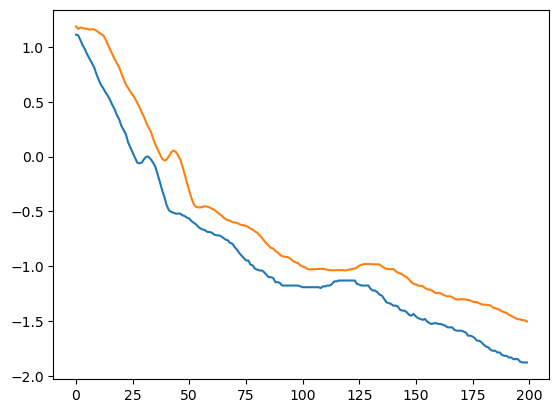

In [242]:
# plt.plot(targets_test[-3000:, 0])
# plt.plot(targets_test[-3000:, 1])
plt.plot(targets_test[-200:])
plt.plot(preds[-200:])
plt.show()

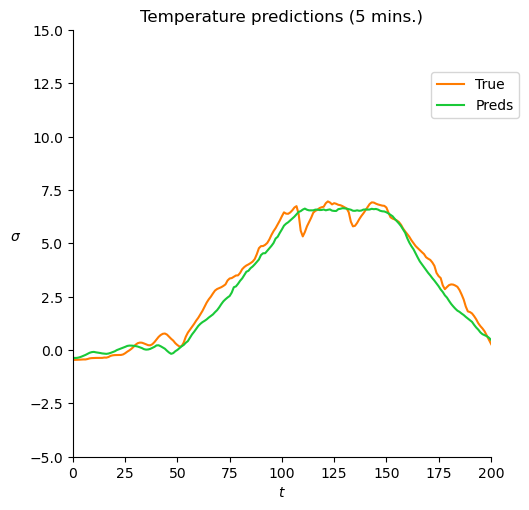

In [939]:
## preds_df = pd.DataFrame(data=[targets_test / 10, np.squeeze(preds) / 10]).T
preds_df = pd.DataFrame(data=[np.squeeze(targets_test), np.squeeze(preds)]).T
preds_df.columns = ['True', 'Preds']
# preds_df.index = data.time.date.iloc[-5760:]

ax = sns.relplot(
    data=preds_df, #.iloc[:12000],
    kind='line',
    palette=sns.color_palette('bright')[1:3],
    linewidth=1.5,
    markers=False,
    dashes=False
)

# ax.set_xticklabels(step=2)
sns.move_legend(ax, loc='upper right', frameon=True, bbox_to_anchor=(0.9, 0.9))
plt.xlim(0, 200)
plt.ylim(-5, 15)
plt.xlabel('$t$')
# plt.ylabel('C$^{\circ}$', rotation=0, labelpad=20)
plt.ylabel('$\sigma$', rotation=0, labelpad=10)
plt.title('Temperature predictions (5 mins.)')
# plt.savefig(plot_path + 'temp_diff_model_preds.png', bbox_inches='tight', dpi=200)
plt.show()

### Temp preds w. Kalman filter

In [311]:
class kalmanFilter():
    
    def __init__(self, Q, R):
        
        # init hyperparams
        self.Q = Q
        self.R = R
        
        # init measurements
        self.x = 0
        self.x_pre = 0
        self.p = 1
        self.p_pre = 1
        self.k = 1
        
    def reset(self, x):
        # reset all measurements
        self.x = x
        self.x_pre = x
        self.p = 0
        self.p_pre = 0
        self.k = 0
        
    def update(self, measurement):
        # time update
        self.x_pre = self.x
        self.p_pre = self.p + self.Q
        
        # measurement update
        self.k = self.p_pre / (self.p_pre + self.R)
        self.x = self.x_pre + self.k * (measurement - self.x_pre)
        self.p = (1 - self.k) * self.p_pre
        
        return self.x

In [944]:
test_seqs = sequences_test.copy()
test_seqs[:, -t_steps:, 0] += 2.0
test_seqs[:, -t_steps:, 3] += 2.0
# test_seqs[:, :, 1] += 1.0

# test_seqs[:, :, 1] += 2
# test_seqs[:, :, 4] += 2

test_preds = np.squeeze(model.predict([temps_test, test_seqs]))

71/71 [==============================] - 0s 5ms/step


In [945]:
# Q = 1e-4
# R = 1e-10
# kalman = kalmanFilter(Q, R)

# preds_kalm = []
# for temp, pred in zip(targets_test[:-1], test_preds[1:]):
#     kalman.reset(temp)
#     pred_kalm = kalman.update(pred)
    
#     preds_kalm.append(pred_kalm)

# # preds_kalm = [targets_test[0]]
# # kalman.reset(preds_kalm[0])
# # for pred in preds[1:]:
    
# #     pred_kalm = kalman.update(pred)
# #     preds_kalm.append(pred_kalm)


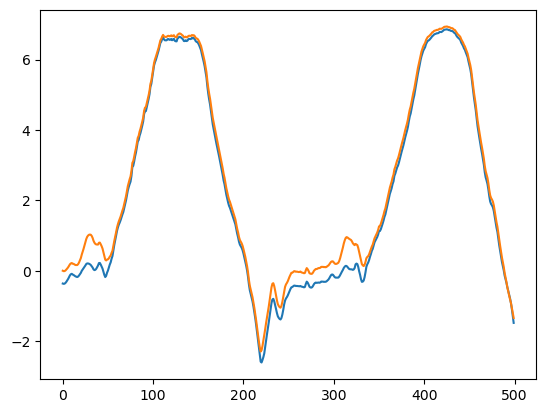

In [946]:
plt.plot(preds[:500])
plt.plot(test_preds[:500])
# plt.plot(temps_test[:2500])
# plt.plot(targets_test[:1500])
plt.show()